In [2]:
# Pandas and numpy for analysing and preparing data
import pandas as pd
from pandas.io.json import json_normalize
pd.set_option('display.max_columns', None) # display all columns of a df inline
pd.set_option('display.max_rows', None) # display all rows of a df inline
import numpy as np

import geopandas as gpd

# Matplotlib colors
import matplotlib.cm as cm
import matplotlib.colors as colors

# Handling URL queries
import json
import requests

# Folium and geopy handle and display geospatial data
import folium # display data on interactive map
from geopy.geocoders import Nominatim # get langitude and longitude for an address

# Import BeautifulSoup for scraping table from wiki-page
from bs4 import BeautifulSoup

# To cluster neighborhoods
from sklearn.cluster import KMeans

# Read environment variables with foursquare API credentials
import os

## Get data for neighborhoods in Duesseldorf

https://public.opendatasoft.com provides data on the borders of the neighborhoods, as well as on the population.

In [236]:
# Download GeoJSON for neighborhoods of Duesseldorf
!wget --quiet 'https://opendata.duesseldorf.de/sites/default/files/Stadtteile_WGS84_4326.geojson' -O dus_neighborhoods.geojson

# Download JSON with size of population and their nationality per neighborhood in Duesseldorf (2018)
# Description of Data: https://opendata.duesseldorf.de/dataset/staatsangeh%C3%B6rigkeiten-der-d%C3%BCsseldorfer-bev%C3%B6lkerung-nach-stadtteilen
!wget --quiet 'https://opendata.duesseldorf.de/api/action/datastore/search.json?resource_id=74361904-6555-411f-9ccd-f6f29c29b64c&limit=200' -O dus_nationality.json

# Download CSV (JSON file was not available) with total size of population per neighborhood in Duesseldorf (2018)
# Description of Data: https://opendata.duesseldorf.de/dataset/einwohnerzahl-d%C3%BCsseldorf-seit-2012-einwohnermeldedaten
!wget --quiet 'https://opendata.duesseldorf.de/sites/default/files/Bev%C3%B6lkerungsstand%20in%20den%20Stadtteilen%20seit%202012_0.csv' -O dus_population.csv

#### Extract ID, name and borders of each neighborhood

In [258]:
with open('dus_neighborhoods.geojson', 'r') as f:
    json_decode = json.load(f)

neighborhoods = [{'Neighborhood': item['properties']['Name'],
                  'Neighborhood ID': f'{item["properties"]["Stadtteil"]:03d}',
                  'geometry': item['geometry']
                 }
                 for item in json_decode['features']
                ]

neighborhoods = pd.DataFrame(neighborhoods).set_index('Neighborhood ID')
print(neighborhoods.shape)
neighborhoods.head()

(50, 2)


,Neighborhood,geometry
Neighborhood ID,,
054,Wittlaer,"{'type': 'Polygon', 'coordinates': [[[6.766232..."
055,Angermund,"{'type': 'Polygon', 'coordinates': [[[6.809524..."
043,Lörick,"{'type': 'Polygon', 'coordinates': [[[6.746101..."
042,Heerdt,"{'type': 'Polygon', 'coordinates': [[[6.735601..."
041,Oberkassel,"{'type': 'Polygon', 'coordinates': [[[6.768680..."


In [237]:
with open('dus_nationality.json', 'r') as f:
    json_decode = json.load(f)

# json_decode
assign_kwargs = {'Neighborhood ID': lambda x: x.index.str[0:3]}

nationality = [item for item in json_decode['result']['records']]
nationality = (pd.DataFrame(nationality).drop('Staatenschlüssel', axis=1) # ID of primary nationality not required
                                        .set_index('Erste Staatsangehörigkeit')
                                        .transpose()
                                        .assign(**assign_kwargs) # Extract Neighborhood ID
                                        .set_index('Neighborhood ID')
                                        .replace('.', 0) # Due to confidentiality reasons, not all numbers are reported, this is indicated by value '.'
                                        .astype('int64')                                      
             )

print(nationality.shape)
nationality.head()

(50, 191)


Erste Staatsangehörigkeit,Deutschland,Gesamtjugoslawien (alt),Albanien,Bosnien und Herzegowina,Andorra,Belgien,Bulgarien,Dänemark,Estland,Finnland,Frankreich,Kroatien,Slowenien,Serbien und Montenegro (alt),Serbien mit Kosovo (alt),Griechenland,Irland,Island,Italien,Jugoslawien (alt),Lettland,Montenegro,Liechtenstein,Litauen,Luxemburg,Mazedonien,Malta,Moldau,Niederlande,Norwegen,Kosovo,Österreich,Polen,Portugal,Rumänien,Slowakei,Schweden,Schweiz,Sowjetunion (alt),Russische Föderation,Spanien,Tschechoslowakei (alt),Türkei,Tschechische Republik,Ungarn,Ukraine,Vereinigtes Königreich,Weißrussland,Serbien,Zypern,Britische Kron- und Überseegebiete,Britisch abhängige Gebiete in Europe,Algerien,Angola,Eritrea,Äthiopien,Lesotho,Botsuana,Benin,Dschibuti,Cote d'Ivoire,Nigeria,Simbabwe,Gabun,Gambia,Ghana,Mauretanien,Cabo Verde,Kenia,"Kongo, Republik","Kongo, Dem.Republik (Zaire)",Liberia,Libyen,Madagaskar,Mali,Marokko,Mauritius,Mosambik,Niger,Malawi,Sambia,Burkina Faso,Guinea-Bissau,Guinea,Kamerun,Südafrika,Ruanda,Namibia,Senegal,Seychellen,Sierra Leone,Somalia,Sudan,Sudan (ohne Südsudan),Swasiland,Tansania,Togo,Tschad,Tunesien,Uganda,Ägypten,Zentralafrikanische Rep.,Burundi,Barbados,Argentinien,Bahamas,Bolivien,Brasilien,Guyana,Belize,Chile,Dominica,Costa Rica,Dominikanische Rep.,Ecuador,El Salvador,Guatemala,Haiti,Honduras,Kanada,Kolumbien,Kuba,Mexiko,Nicaragua,Jamaika,Panama,Paraguay,Peru,Suriname,Uruguay,St.Lucia,Venezuela,Vereinigte Staaten,St.Vincent u.d.Grenadinen,St.Kitts und Nevis,Trinidad und Tobago,(Hongkong),(Macau),Jemen,Armenien,Afghanistan,Bahrain,Aserbaidschan,Myanmar,Georgien,Sri Lanka,Vietnam,"Korea, Dem.Volksrep.",Indien,Indonesien,Irak,Iran,Israel,Japan,Kasachstan,Jordanien,Kambodscha,Katar,Kuwait,Laos,Kirgistan,Libanon,Oman,Mongolei,Nepal,(Palästinensische Gebiete),Bangladesch,Pakistan,Philippinen,Taiwan,"Korea, Republik",Verein.arab.Emirate,Tadschikistan,Turkmenistan,Saudi-Arabien,Singapur,Syrien,Thailand,Usbekistan,China,Malaysia,Britisch abhängige Gebiete in Asien,Übriges Asien,Australien,Fidschi,Vanuatu,Neuseeland,(unbekanntes Ausland),staatenlos,ungeklärt,ohne Angabe
Neighborhood ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
011,1492,0,5,5,0,0,7,5,0,0,26,25,5,0,0,24,16,0,89,0,3,0,0,0,0,24,0,0,17,0,8,10,25,40,31,3,10,5,0,24,74,0,24,3,13,10,25,0,8,0,0,0,0,0,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,3,0,0,0,0,0,0,19,0,0,0,0,0,0,0,0,0,0,0,4,4,0,6,0,0,0,0,0,0,0,0,0,52,0,0,0,0,0,0,0,0,0,0,0,8,11,11,0,20,0,7,13,5,17,0,0,0,16,0,0,0,4,0,0,0,0,8,0,0,0,19,0,0,0,0,0,29,12,0,12,0,0,0,8,0,0,0,0,0,0,0
012,1863,0,3,3,0,0,3,3,0,0,15,13,0,0,0,16,0,0,36,0,0,0,0,0,0,0,0,0,28,0,0,19,15,7,4,0,0,5,0,19,29,0,12,0,0,7,27,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,9,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,18,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,5,0,0,5,0,24,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,11,0,0,0,0,0,6,0,0,20,0,0,0,0,0,0,0,0,0,0,0
013,8376,0,49,55,0,34,164,13,0,3,122,149,9,49,0,480,20,0,247,0,50,7,0,33,5,81,0,4,102,0,81,59,288,91,352,15,16,15,0,130,168,0,255,11,63,86,107,12,142,12,0,0,7,0,8,0,0,0,0,0,0,11,3,0,11,52,0,0,0,5,0,0,134,0,0,84,0,0,0,0,0,0,0,3,5,0,0,0,3,0,5,0,0,0,0,0,11,0,51,0,27,0,0,0,0,0,0,50,0,0,5,0,0,4,0,0,0,0,0,22,11,5,13,0,0,0,3,4,0,3,0,3,69,0,0,0,0,0,0,0,32,0,16,0,26,34,56,6,228,13,124,140,14,697,4,17,0,13,3,3,0,20,0,3,12,0,6,36,17,13,145,0,0,0,12,6,234,65,3,285,12,15,0,9,0,0,0,0,10,20,0
014,25395,0,31,54,0,55,73,15,9,39,342,195,19,55,0,390,37,0,591,0,22,9,0,26,14,91,0,3,195,14,47,153,401,118,165,17,48,45,0,230,350,0,382,33,65,162,265,25,120,27,0,0,11,0,4,0,0,0,0,0,0,12,10,0,10,27,0,0,11,0,0,0,40,3,0,94,0,0,0,0,0,0,3,5,6,12,0,0,5,0,4,0,0,0,0,0,0,0,31,0,36,0,0,0,4,0,4,61,0,0,8,0,3,3,0,3,0,0,0,60,28,6,27,0,0,3,0,15,0,0,0,13,185,0,0,0,0,0,0,13,29,0,10,0,

**Finding:** Due to confidentiality, not all numbers are available. The potential effect could only be evaluated by comparing the sum of available population per Neighborhood vs. total population of Neighborhoods. This figure, however, is not available right now.

Drop all nationalities, for which no person has been reported.

In [238]:
no_citizens = nationality.columns[(nationality.sum() == 0)]
print(f'{len(no_citizens)} nationalities have no citizen reported.')
print(f'The nationalities are: {", ".join(no_citizens)}')
nationality.drop(no_citizens, axis=1, inplace=True)
print(f'{nationality.shape[1]} nationalities remain.')

45 nationalities have no citizen reported.
The nationalities are: Gesamtjugoslawien (alt), Andorra, Jugoslawien (alt), Malta, Sowjetunion (alt), Tschechoslowakei (alt), Britische Kron- und Überseegebiete, Britisch abhängige Gebiete in Europe, Lesotho, Botsuana, Dschibuti, Gabun, Mauretanien, Cabo Verde, Liberia, Niger, Malawi, Namibia, Seychellen, Sudan (ohne Südsudan), Swasiland, Tschad, Uganda, Zentralafrikanische Rep., Barbados, Bahamas, Guyana, Belize, Dominica, Guatemala, Haiti, Honduras, Nicaragua, Suriname, St.Lucia, St.Vincent u.d.Grenadinen, St.Kitts und Nevis, Trinidad und Tobago, (Hongkong), (Macau), Oman, (Palästinensische Gebiete), Verein.arab.Emirate, Fidschi, Vanuatu
146 nationalities remain.


In [242]:
nationality.sum().sort_values(ascending=False)

Erste Staatsangehörigkeit
Deutschland                            493945
Türkei                                  12599
Griechenland                            10318
Polen                                    9107
Italien                                  7915
Syrien                                   6244
Japan                                    5976
Rumänien                                 5032
China                                    4608
Spanien                                  4573
Russische Föderation                     4517
Marokko                                  4496
Mazedonien                               3915
Kroatien                                 3723
Ukraine                                  3304
Frankreich                               3302
Iran                                     3264
Indien                                   3217
Irak                                     3177
Serbien                                  3173
Niederlande                              2599
Vereinig

#### Import data with total population size

In [243]:
names = ['Neighborhood ID', 'Neighborhood'] + [str(x) for x in range(2012, 2019)]
population_import = pd.read_csv('dus_population.csv', sep=';', header=0, names=names)
population = pd.DataFrame({'Neighborhood ID': population_import["Neighborhood ID"].map(lambda x: f'{x:03d}'),
                           'Population': population_import['2018']}
                         ).set_index('Neighborhood ID')
print(population.shape)
population.head()

(50, 1)


,Population
Neighborhood ID,
011,2404
012,2285
013,14954
014,33064
015,20610


In [244]:
population_total = (nationality.sum(axis=1)
                               .to_frame(name='Nationality')
                               .join(population)
                               .assign(PercMissing=lambda x: round((x['Population'] - x['Nationality']) / x['Population'],2))
                               .sort_values(by='PercMissing', ascending=False)
                   )
population_total.PercMissing.describe()

count    50.000000
mean      0.007200
std       0.017501
min       0.000000
25%       0.000000
50%       0.000000
75%       0.010000
max       0.120000
Name: PercMissing, dtype: float64

On average less than 1% of popluation is missing, with a maximum value of 12% in one neighborhood. 75% of deviations are below 1%. The impact of the missing information might not have a significant impact on the overall results.

#### Derive the top nationalities per neighborhood

In [245]:
def return_top_nationalities(neighborhood, top, threshold=1):
    top += 1
    top_nationalities = (neighborhood.sort_values(ascending=False)
                                     .head(top)[1:top] # Germany is in all neighborhoods top 1 nationality, therefore drop it
                                     .index
                        )
    return top_nationalities

In [246]:
top = 10
top_nationalities_dict = {}
nationality_t = nationality.apply(lambda x: x / x.sum(), axis=1).transpose()

for neighborhood in nationality_t:
    top_nationalities_dict[neighborhood] = return_top_nationalities(nationality_t[neighborhood], top)

columns = ['1st', '2nd', '3rd'] + [f'{str(x)}th' for x in range(4, top + 1)]
top_nationalities = pd.DataFrame(top_nationalities_dict).transpose()
top_nationalities.columns = columns
top_nationalities.head()

,1st,2nd,3rd,4th,5th,6th,7th,8th,9th,10th
011,Italien,Spanien,Vereinigte Staaten,Portugal,Rumänien,Syrien,Frankreich,Vereinigtes Königreich,Polen,Kroatien
012,Italien,Spanien,Niederlande,Vereinigtes Königreich,Japan,China,Russische Föderation,Österreich,Vereinigte Staaten,Griechenland
013,Japan,Griechenland,Rumänien,Polen,China,Türkei,Italien,Syrien,Indien,Spanien
014,Italien,Japan,Polen,Griechenland,Türkei,Spanien,Frankreich,Indien,Vereinigtes Königreich,China
015,Türkei,Griechenland,Italien,Polen,Syrien,Indien,Rumänien,Spanien,Russische Föderation,Japan


In [259]:
# Join neighborhoods and nationality data on 'Neighborhood ID' and calculate percentage of nationality per neighborhood
dus_data = neighborhoods.merge(top_nationalities,
                               how='inner',
                               left_on='Neighborhood ID',
                               right_index=True
                              )
print(dus_data.shape)
dus_data.head()

(50, 12)


,Neighborhood,geometry,1st,2nd,3rd,4th,5th,6th,7th,8th,9th,10th
Neighborhood ID,,,,,,,,,,,,
054,Wittlaer,"{'type': 'Polygon', 'coordinates': [[[6.766232...",Vereinigte Staaten,Vereinigtes Königreich,China,Niederlande,"Korea, Republik",Spanien,Polen,Russische Föderation,Indien,Österreich
055,Angermund,"{'type': 'Polygon', 'coordinates': [[[6.809524...",Syrien,Vereinigtes Königreich,Polen,Italien,China,Österreich,Spanien,Türkei,Russische Föderation,Niederlande
043,Lörick,"{'type': 'Polygon', 'coordinates': [[[6.746101...",China,Japan,Türkei,Polen,Griechenland,Italien,Russische Föderation,Ukraine,Rumänien,Spanien
042,Heerdt,"{'type': 'Polygon', 'coordinates': [[[6.735601...",Japan,China,Polen,Griechenland,Türkei,Rumänien,Portugal,Mazedonien,Italien,Marokko
041,Oberkassel,"{'type': 'Polygon', 'coordinates': [[[6.768680...",Japan,China,Griechenland,Italien,Spanien,Frankreich,Vereinigte Staaten,Türkei,Österreich,Niederlande


#### Visualize data on a map

In [251]:
dus_centre = Nominatim(user_agent='dus')
location = dus_centre.geocode(query='Düsseldorf', country_codes='de')
dus_latitude = location.latitude
dus_longitude = location.longitude

print(f'The coordinates of Duesseldorf are {dus_latitude}, {dus_longitude}.')

The coordinates of Duesseldorf are 51.2254018, 6.7763137.


In [273]:
# create map centered on Duesseldorf
map_dus = folium.Map(location=[dus_latitude, dus_longitude],
                     zoom_start=11,
                     min_zoom=10,
                     max_zoom=19,
                     zoom_control=False
                    )

# for code, lat, lng in zip(dus_data['Postal Code'], dus_data['Latitude'], dus_data['Longitude']):
#     folium.Marker(location=[lat, lng],
#                   icon=folium.DivIcon(html=f"""<div style="color: black;">{code}</div>""")
#                  ).add_to(map_dus)

# generate choropleth map to show postal code areas
folium.GeoJson(data=my_dict
#                tooltip=folium.features.GeoJsonTooltip(['Neighborhood', '1st', '2nd', '3rd'])
              ).add_to(map_dus)

map_dus

In [101]:
# Build one DataFrame with top venues per neighborhood
def getNearbyVenues(postal_codes, names, latitudes, longitudes, radius=500):
    
    venues_list = []
    # Iterate through list of neighborhoods
    for postal_code, name, lat, lng in zip(postal_codes, names, latitudes, longitudes):
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore'
        params = dict(client_id=os.getenv('FS_CLIENT_ID'),
                      client_secret=os.getenv('FS_CLIENT_SECRET'),
                      v='20180323',
                      ll=f'{lat},{lng}',
                      radius=radius,
                      limit=100
                     )

        # make the GET request
        results = requests.get(url=url, params=params).json()
        try:
            results = results['response']['groups'][0]['items']

        except:
            print('Something went wrong with the query. Here are some information:')
            print(f'Postal Code: {postal_code}, Section: {section}')
            print(results)
        # List of list with only relevant information per venue
        # Multiple entries per venue, if multiple categories have been assigned
        for v in results: 
            venues_list.append([(postal_code,
                                 name,
                                 lat,
                                 lng,
                                 v['venue']['name'],
                                 v['venue']['location']['lat'],
                                 v['venue']['location']['lng'],
                                 n['name']) for n in v['venue']['categories']]
                              )

        # Create DataFrame
        columns = ['Postal Code', 'Neighborhood', 'Neighborhood Latitude', 'Neighborhood Longitude',
                   'Venue', 'Venue Latitude', 'Venue Longitude', 'Venue Category']
        nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
        nearby_venues.columns = columns
    
    return(nearby_venues)

In [102]:
# Create DataFrame with one row per venue returned matching the neighborhood it belongs to 
dus_venues = getNearbyVenues(postal_codes=dus_data['Postal Code'],
                             names=dus_data['Neighborhood'],
                             latitudes=dus_data['Latitude'],
                             longitudes=dus_data['Longitude']
                            )

In [103]:
dus_venues.head()

,Postal Code,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,40210,"Friedrichstadt, Stadtmitte",51.22151,6.789388,Hanaro Markt,51.222006,6.788910,Grocery Store
1,40210,"Friedrichstadt, Stadtmitte",51.22151,6.789388,Kushi Tei of Tokyo,51.223275,6.789558,Japanese Restaurant
2,40210,"Friedrichstadt, Stadtmitte",51.22151,6.789388,Takumi,51.223429,6.788531,Ramen Restaurant
3,40210,"Friedrichstadt, Stadtmitte",51.22151,6.789388,Korea Haus,51.221820,6.787069,Korean Restaurant
4,40210,"Friedrichstadt, Stadtmitte",51.22151,6.789388,Grill House 56,51.222084,6.786261,Souvlaki Shop


In [31]:
dus_venues.to_pickle('dus_venues.pkl', compression="gzip")

In [106]:
venue_counts = (dus_venues['Postal Code'].value_counts()
                                        .to_frame()
                                        .reset_index(drop=False)
                                        .rename(columns={'index':'Postal Code', 'Postal Code':'Venues'})
               )
venue_counts

,Postal Code,Venues
0,40213,100
1,40212,100
2,40210,100
3,40219,78
4,40215,78
5,40217,65
6,40477,49
7,40211,47
8,40479,45
9,40476,43


For 35 of the 37 postal code areas, min. one venue has been returned.

In [115]:
len(dus_venues['Postal Code'].value_counts())

35

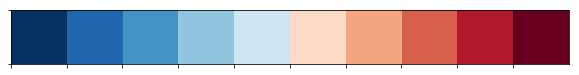

In [118]:
color_scale = np.array(['#053061','#2166ac','#4393c3','#92c5de','#d1e5f0','#fddbc7','#f4a582','#d6604d','#b2182b','#67001f'])
sns.palplot(sns.color_palette(color_scale))

In [114]:
# Create map centered on Duesseldorf
map_dus = folium.Map(location=[dus_latitude, dus_longitude],
                     zoom_start=11,
                     min_zoom=10,
                     max_zoom=19,
                     zoom_control=False
                    )

# for code, lat, lng in zip(dus_data['Postal Code'], dus_data['Latitude'], dus_data['Longitude']):
#     folium.Marker(location=[lat, lng],
#                   icon=folium.DivIcon(html=f"""<div style="color: black;">{code}</div>""")
#                  ).add_to(map_dus)

# Define bins for coloring
threshold_scale = list(range(0,101,20))
threshold_scale[-1] = threshold_scale[-1] + 0.1

# Generate choropleth map to show postal code areas
folium.Choropleth(
    geo_data='dus_postal_code_geo.json',
    key_on='feature.properties.plz',
    data=venue_counts,
    columns=['Postal Code', 'Venues'],
    fill_color='BuGn',
    threshold_scale=threshold_scale,
    fill_opacity=0.7, 
    line_opacity=0.5,
    legend_name='Venues per Postal Code'
).add_to(map_dus)

map_dus

In [130]:
dus_venues_one_hot = pd.get_dummies(dus_venues[['Postal Code', 'Venue Category']], columns=['Venue Category'])

,Postal Code,Venue Category_Advertising Agency,Venue Category_Airport Terminal,Venue Category_American Restaurant,Venue Category_Argentinian Restaurant,Venue Category_Art Gallery,Venue Category_Art Museum,Venue Category_Arts & Crafts Store,Venue Category_Asian Restaurant,Venue Category_Athletics & Sports,Venue Category_Automotive Shop,Venue Category_BBQ Joint,Venue Category_Bakery,Venue Category_Bank,Venue Category_Bar,Venue Category_Beach,Venue Category_Beer Bar,Venue Category_Beer Garden,Venue Category_Beer Store,Venue Category_Bistro,Venue Category_Bookstore,Venue Category_Boutique,Venue Category_Bowling Alley,Venue Category_Brazilian Restaurant,Venue Category_Breakfast Spot,Venue Category_Brewery,Venue Category_Bubble Tea Shop,Venue Category_Building,Venue Category_Burger Joint,Venue Category_Bus Stop,Venue Category_Business Service,Venue Category_Butcher,Venue Category_Café,Venue Category_Castle,Venue Category_Chinese Restaurant,Venue Category_Chocolate Shop,Venue Category_Cigkofte Place,Venue Category_Clothing Store,Venue Category_Cocktail Bar,Venue Category_Coffee Shop,Venue Category_Colombian Restaurant,Venue Category_Comedy Club,Venue Category_Comfort Food Restaurant,Venue Category_Cosmetics Shop,Venue Category_Cupcake Shop,Venue Category_Currywurst Joint,Venue Category_Deli / Bodega,Venue Category_Department Store,Venue Category_Dessert Shop,Venue Category_Dim Sum Restaurant,Venue Category_Diner,Venue Category_Discount Store,Venue Category_Dive Bar,Venue Category_Doner Restaurant,Venue Category_Donut Shop,Venue Category_Drugstore,Venue Category_Electronics Store,Venue Category_Event Space,Venue Category_Falafel Restaurant,Venue Category_Farmers Market,Venue Category_Fast Food Restaurant,Venue Category_Flea Market,Venue Category_Food Court,Venue Category_Fountain,Venue Category_French Restaurant,Venue Category_Frozen Yogurt Shop,Venue Category_Fruit & Vegetable Store,Venue Category_Furniture / Home Store,Venue Category_Gas Station,Venue Category_Gastropub,Venue Category_General Entertainment,Venue Category_German Restaurant,Venue Category_Gift Shop,Venue Category_Gourmet Shop,Venue Category_Greek Restaurant,Venue Category_Grocery Store,Venue Category_Gym,Venue Category_Gym / Fitness Center,Venue Category_Hardware Store,Venue Category_History Museum,Venue Category_Hobby Shop,Venue Category_Hockey Rink,Venue Category_Hookah Bar,Venue Category_Hostel,Venue Category_Hotel,Venue Category_Hotel Bar,Venue Category_Ice Cream Shop,Venue Category_Indian Restaurant,Venue Category_Indie Movie Theater,Venue Category_Insurance Office,Venue Category_Intersection,Venue Category_Irish Pub,Venue Category_Italian Restaurant,Venue Category_Japanese Restaurant,Venue Category_Jazz Club,Venue Category_Jewelry Store,Venue Category_Jewish Restaurant,Venue Category_Juice Bar,Venue Category_Kebab Restaurant,Venue Category_Korean Restaurant,Venue Category_Lake,Venue Category_Laser Tag,Venue Category_Laundromat,Venue Category_Light Rail Station,Venue Category_Liquor Store,Venue Category_Lounge,Venue Category_Market,Venue Category_Massage Studio,Venue Category_Men's Store,Venue Category_Metro Station,Venue Category_Mexican Restaurant,Venue Category_Middle Eastern Restaurant,Venue Category_Mini Golf,Venue Category_Miscellaneous Shop,Venue Category_Mobile Phone Shop,Venue Category_Modern European Restaurant,Venue Category_Museum,Venue Category_Nightclub,Venue Category_Office,Venue Category_Opera House,Venue Category_Optical Shop,Venue Category_Organic Grocery,Venue Category_Palace,Venue Category_Park,Venue Category_Pastry Shop,Venue Category_Pedestrian Plaza,Venue Category_Perfume Shop,Venue Category_Pharmacy,Venue Category_Photography Studio,Venue Category_Pizza Place,Venue Category_Platform,Venue Category_Playground,Venue Category_Plaza,Venue Category_Poke Place,Venue Category_Polish Restaurant,Venue Category_Pool,Venue Category_Pool Hall,Venue Category_Portuguese Restaurant,Venue Category_Pub,Venue Category_Ramen Restaurant,Venue Category_Record 

In [134]:
dus_venues_mean = dus_venues_one_hot.groupby(by='Postal Code').agg('mean').reset_index(drop=False)

,Postal Code,Venue Category_Advertising Agency,Venue Category_Airport Terminal,Venue Category_American Restaurant,Venue Category_Argentinian Restaurant,Venue Category_Art Gallery,Venue Category_Art Museum,Venue Category_Arts & Crafts Store,Venue Category_Asian Restaurant,Venue Category_Athletics & Sports,Venue Category_Automotive Shop,Venue Category_BBQ Joint,Venue Category_Bakery,Venue Category_Bank,Venue Category_Bar,Venue Category_Beach,Venue Category_Beer Bar,Venue Category_Beer Garden,Venue Category_Beer Store,Venue Category_Bistro,Venue Category_Bookstore,Venue Category_Boutique,Venue Category_Bowling Alley,Venue Category_Brazilian Restaurant,Venue Category_Breakfast Spot,Venue Category_Brewery,Venue Category_Bubble Tea Shop,Venue Category_Building,Venue Category_Burger Joint,Venue Category_Bus Stop,Venue Category_Business Service,Venue Category_Butcher,Venue Category_Café,Venue Category_Castle,Venue Category_Chinese Restaurant,Venue Category_Chocolate Shop,Venue Category_Cigkofte Place,Venue Category_Clothing Store,Venue Category_Cocktail Bar,Venue Category_Coffee Shop,Venue Category_Colombian Restaurant,Venue Category_Comedy Club,Venue Category_Comfort Food Restaurant,Venue Category_Cosmetics Shop,Venue Category_Cupcake Shop,Venue Category_Currywurst Joint,Venue Category_Deli / Bodega,Venue Category_Department Store,Venue Category_Dessert Shop,Venue Category_Dim Sum Restaurant,Venue Category_Diner,Venue Category_Discount Store,Venue Category_Dive Bar,Venue Category_Doner Restaurant,Venue Category_Donut Shop,Venue Category_Drugstore,Venue Category_Electronics Store,Venue Category_Event Space,Venue Category_Falafel Restaurant,Venue Category_Farmers Market,Venue Category_Fast Food Restaurant,Venue Category_Flea Market,Venue Category_Food Court,Venue Category_Fountain,Venue Category_French Restaurant,Venue Category_Frozen Yogurt Shop,Venue Category_Fruit & Vegetable Store,Venue Category_Furniture / Home Store,Venue Category_Gas Station,Venue Category_Gastropub,Venue Category_General Entertainment,Venue Category_German Restaurant,Venue Category_Gift Shop,Venue Category_Gourmet Shop,Venue Category_Greek Restaurant,Venue Category_Grocery Store,Venue Category_Gym,Venue Category_Gym / Fitness Center,Venue Category_Hardware Store,Venue Category_History Museum,Venue Category_Hobby Shop,Venue Category_Hockey Rink,Venue Category_Hookah Bar,Venue Category_Hostel,Venue Category_Hotel,Venue Category_Hotel Bar,Venue Category_Ice Cream Shop,Venue Category_Indian Restaurant,Venue Category_Indie Movie Theater,Venue Category_Insurance Office,Venue Category_Intersection,Venue Category_Irish Pub,Venue Category_Italian Restaurant,Venue Category_Japanese Restaurant,Venue Category_Jazz Club,Venue Category_Jewelry Store,Venue Category_Jewish Restaurant,Venue Category_Juice Bar,Venue Category_Kebab Restaurant,Venue Category_Korean Restaurant,Venue Category_Lake,Venue Category_Laser Tag,Venue Category_Laundromat,Venue Category_Light Rail Station,Venue Category_Liquor Store,Venue Category_Lounge,Venue Category_Market,Venue Category_Massage Studio,Venue Category_Men's Store,Venue Category_Metro Station,Venue Category_Mexican Restaurant,Venue Category_Middle Eastern Restaurant,Venue Category_Mini Golf,Venue Category_Miscellaneous Shop,Venue Category_Mobile Phone Shop,Venue Category_Modern European Restaurant,Venue Category_Museum,Venue Category_Nightclub,Venue Category_Office,Venue Category_Opera House,Venue Category_Optical Shop,Venue Category_Organic Grocery,Venue Category_Palace,Venue Category_Park,Venue Category_Pastry Shop,Venue Category_Pedestrian Plaza,Venue Category_Perfume Shop,Venue Category_Pharmacy,Venue Category_Photography Studio,Venue Category_Pizza Place,Venue Category_Platform,Venue Category_Playground,Venue Category_Plaza,Venue Category_Poke Place,Venue Category_Polish Restaurant,Venue Category_Pool,Venue Category_Pool Hall,Venue Category_Portuguese Restaurant,Venue Category_Pub,Venue Category_Ramen Restaurant,Venue Category_Record 